In [16]:
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [17]:
# create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
# config

# specify the paths to the directory where the data is stored
trainpath = '../dataset/train'
testpath = '../dataset/test'
valpath = '../dataset/validation'

# specify input size (images are square), batch size, number of channels, number of classes, and number of epochs

IMG_SIZE=180
BATCH_SIZE=32
CHANNELS=3
EPOCHS=25
N_CLASSES = 2

In [19]:
# define transformations

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# simple transform

transform1 = transforms.Compose([
    transforms.ToTensor(),
])

# training, validation, test data

train_dataset = datasets.ImageFolder(trainpath, transform=transform)
val_dataset = datasets.ImageFolder(valpath, transform=transform)
test_dataset = datasets.ImageFolder(testpath, transform=transform)

# plotting dataset without complicated transformations

datasetforplot = datasets.ImageFolder(trainpath, transform=transform1)


# data loaders

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

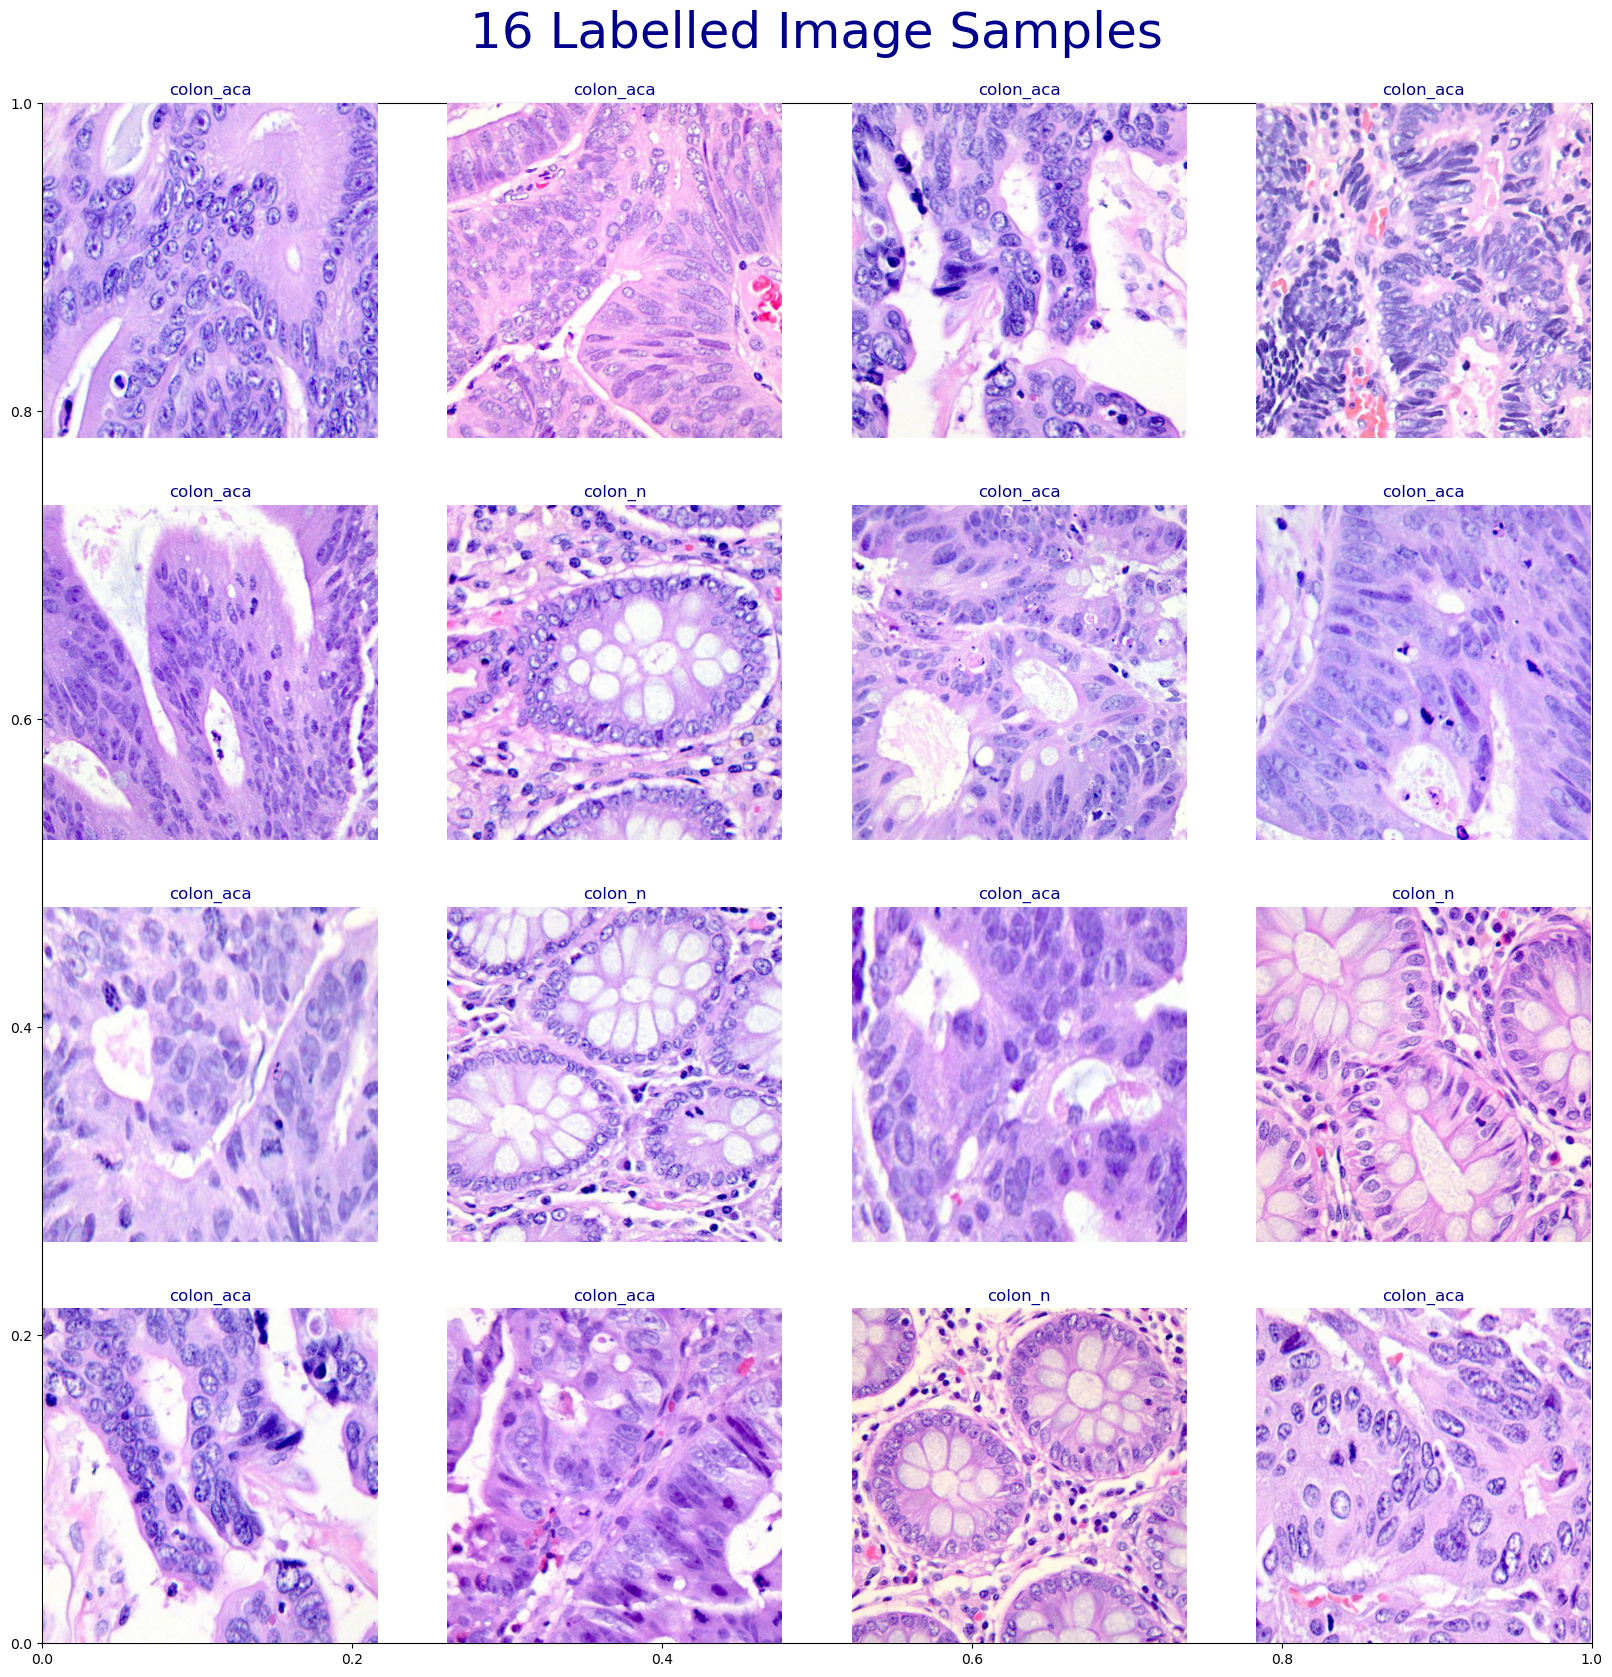

In [20]:
plt.figure(figsize=(20,20))
plt.title('16 Labelled Image Samples', fontsize= 36, pad = 40, color = 'darkblue')

for i in range(16):
    randint = np.random.randint(0, 7000)
    plt.subplot(4, 4, i+1)
    image = (datasetforplot[randint][0]).permute(1, 2, 0)      # scales data to range (0 - 255)
    plt.imshow(image)
    class_name = datasetforplot.classes[datasetforplot[randint][1]]   # get class of image
    plt.title(class_name, color = 'darkblue', fontsize= 12)
    plt.axis('off')

In [11]:
# baseline model

class CNNmodel(nn.Module):
    def __init__ (self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*45*45, 
                      out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096,
                      out_features=output_shape),
            nn.Softmax(dim=1)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)

model_2 = CNNmodel(input_shape=CHANNELS, 
    hidden_units=128, 
    output_shape=N_CLASSES).to(device)

In [13]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode(): 
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1)
            )
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        return test_loss, test_acc


In [14]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

In [15]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.01, momentum=0.9)

In [ ]:
# Train and test model 
torch.manual_seed(42)
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n---------")
    train_loss, train_accuracy = train_step(data_loader=train_loader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    val_loss, val_accuracy = test_step(data_loader=test_loader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )